# <center><FONT COLOR='#2FC220' FONT='Palatino Linotype'> <h1><FONT COLOR='#112050' FACE='Georgia'>Geospatial programming in Python</FONT></h1>  <h2>UC Berkeley D-Lab</h2>  <h6>Sunday October 16, 2016</h6>   </FONT> </center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQduoeBGd_WD3exm8Q3Yi28CaaJFEweQwFGneaGOmEU8UoFmgeRXSndtA" style="float: left; width: 15%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSeUM4U5dSW8No1p8RdeKQ16m4qLvvVzMkCqwoDLt98phmZrmNNUdMXiA" style="float: right; width: 15%; margin-right: 1%; margin-bottom: 0.5em;"> <p style="clear: both;"> 
_________________________________

In [1]:
#IPython functionalities we'll need
from IPython.display import Image, SVG, HTML, IFrame  #display URL images and HTML/webpages

def frame(url):
    return(IFrame(url, width=700, height=350))
    

%matplotlib inline  
#^^plot inline (i.e. within the Jupyter notebook)^^


#Some general-purpose packages and functions we'll use
import pandas as pd
import numpy as np
from collections import Counter as C
from collections import OrderedDict as OD
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import scipy.stats as st


#Python spatial packages we'll be using
from geopy.geocoders import GoogleV3
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import fiona
from shapely.geometry import *
import osmnx as ox
import gdal
import osr


#Set our data directory
    #NOTE: Make sure you've downloaded the data and plopped it into the parent directory of your repo!
data_dir = '../workshop_data/'

---------------------------------
# <u>What is geospatial data?</u>

### _A very brief review_



__Geospatial data__ is any data, whatever the form, that includes data associating it with its proper location on the face of the earth.



Typically, the spatial location of data is expressed using __coordinate pairs__ indicating the position of each point in the dataset.  

Coordinates can be of two general types:

1. __geographic__: expressed as angles in two dimensions that determine points on a globe, using:


- __latitude__: from -90 &deg; at the South Pole to +90 &deg; at the North Pole, with 0&deg; latitude defined at the Equator

and 

- __longitude__: running either from -180&deg; to +180&deg; or from 0&deg; to 360&deg;, with 0&deg; defined at the Greenwich Meridian in either case (_which can sometimes be tricky when working with data!_)  


<img src="http://kartoweb.itc.nl/geometrics/Bitmaps/geographic%20coordinate%20system.gif" alt="list" width="440">
</img>




Geographic coordinates are typically thought of as referring to a location on a __spheroid__ or __ellipsoid__ that serves as a mathematical model (approximation) of the true, lumpy __geoid__ that is our planet. 

(_FYI: The geoid itself is a model, of the surface of the earth's gravity field... but this is getting beyond our realm of concern._)

<img src="http://i0.wp.com/www.icsm.gov.au/mapping/web_images/spheroid_height.jpg" alt="list" width="440">
</img>

Because strict spheroids and ellipsoids do not allow for important local variations in elevation, they are used as the bases for the the defintion of various __geodetic datums__, which then serve as the mathematical models that provide the reference points against which coordinates can be expressed. Thus, the spheroid/ellipsoid and geodetic datum two of the main components we must consider when working the __coordinate reference systems (CRS)__ of our datasets.

2. __cartographic__: expressed as points on Euclidean (planar) axes, after the globe's surface has been orojected onto the plane

Here's an example of one cartographic coordinate scheme, called UTM (Universal Transverse Mercator). In this scheme, a point's location is defined with reference to the lower-left corner (serving as the graph origin) of the UTM quadrant in which it falls.

<img src="https://courses.washington.edu/gis250/lessons/projection/images_av3/utmworld.gif" alt="list" width="500">
</img>


A __projection__ is a scheme for representing the globe's surface on a flat plane. You can literally imagine placing the global next to or inside a regular geometric object, e.g. a plane (yielding a planar projection) or a cylinder (a cylindrical projection) or a cone (conical projection), putting a light inside the globe (jack-o-lantern-style), capturing the image on the cylinder or cone, and then cutting it and unfolfing it flat. There are a number of other such schemes.               

<img src="http://images.flatworldknowledge.com/campbell/campbell-fig02_011.jpg" alt="list" width="450">
</img>

Along with the ellipsoid and the geodetic datum, the projection is the other major defining characteristic of a CRS. We must know the values of all three of these (or, as we'll see, a unique code representing a unique combination of values) that define the CRS of each of our datasets. This is because, when working with multiple datasets, we must reconcile the CRS of all of them before spatial analysis and/or mapping.


Importantly, it is proven impossible to devise a projection that maintains the true areas, sizes, angular relations, and shapes of geographic entities (something's gotta give), so when choosing projections we often want to consider which of these are most important to preserve for our purposes (i.e. do we want an equal-area projection? an equal-angle projection? etc.)      

People have many (sometimes strong) opinions about map projections:

<img src="https://imgs.xkcd.com/comics/map_projections.png" alt="list" width="750">
</img>

-----------------------------------

# Geospatial data typically is stored in one of two common ways:   

### 1. 
__Vector__: Points, lines, or polygons (or sets of these) can be expressed as connected series of points; the number of points used per real-world distance will determine the resolution of this representation (and thus, the level or grain of detail with which we are representing the real-world complexity of a geographic feature (consider, for example, that the most accurate map of the CA coast would be a 1:1 scaled replica of the coast...). Basically, think of a 'connect-the-dots' model.

<img src="http://neondataskills.org/images/dc-spatial-vector/pnt_line_poly.png" alt="list" width="550">
</img>



### 2. 
__Raster__: Continuously spatially distributed variables are often represented by gridded cells, each having a location (which can be canonically as the coordinates of its center, or of its lower-left corner, etcetera) and at least one value (for the variable of interest). Cells will have a fixed cell-size (typically expressed as the real-world distance represented by a cell-side, in either distance or degrees), and this cell-size will determine the resolution (i.e. level of detail) with which we represent the real-world complexity of this variable. Basically, think of a square-grid 'color-by-number' model. (Indeed, digitalphotos are saved as rasters, usually with each cell having 3 values, for red, green, and blue.)         

<img src="http://desktop.arcgis.com/en/arcmap/10.3/manage-data/geodatabases/GUID-885FD35E-8680-4FFE-A3D7-76E473F31B76-web.gif" alt="list" width="700">
</img>


It is important to keep in mind that raster and vector formats are two alternative ways of digitally representing the analog (i.e. real) world. In some cases, one of the two makes much more sense as a representation scheme for a real thing. For example, cities, hard-bounded entities, are usually represented as vector data (either points of polygons); temperature, a continuously distributed variable, is usually represented as raster data (although isotherms could be drawn as polygons!). 

It is also possible, and indeed is common in many geospatial workflows, to convert between raster and vector data (i.e. rasterize/vectorize)

<img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture05/concepts/03%20-%20Geographic%20data%20models_files/image003.gif" alt="list" width="500">
</img>

--------------------------------------

# <u>And what is geospatial analysis?</u>

Geospatial work then involves a whole lot of different operations on or between one or multiple geospatial data layers, in order extract or produce information of interest. 

There is a large number of such operations, but they include (in no particular order):


### Overlays

<img src="http://gsp.humboldt.edu/OLM/Lessons/GIS/06%20Vector%20Analysis%20Attributes/Images/17_VectorOverlay_EX2.png" alt="list" width="500">
</img>


### Buffers

<img src="http://desktop.arcgis.com/en/arcmap/10.3/manage-data/using-sql-with-gdbs/GUID-0D42E244-367F-41BD-B089-9BBFC6115CB7-web.gif" alt="list" width="400">
</img>


### Intersections

<img src="https://www.gaia-gis.it/spatialite-2.1/resource/mbrs.gif" alt="list" width="800">
</img>


### Raster algebra

<img src="http://i0.wp.com/gisgeography.com/wp-content/uploads/2015/05/Land-Surface-Temperature-Subtraction.png" alt="list" width="500">
</img>


### Clipping

<img src="http://3.bp.blogspot.com/-A-fQ20lWqyY/TWQ2ZltmxgI/AAAAAAAAAGQ/a_ktC6lbCRs/s1600/Rasterclip.png" alt="list" width="500">
</img>


### Simulations
(e.g. random walk along a network)

<img src="https://raw.githubusercontent.com/xbwei/Random-Walk-and-Network-Analyze/master/Atlanta_Random_Point.jpg" alt="list" width="500">
</img>


### Spatial statistics
(e.g.  spatial distribution and autocorrelation)

<img src="https://antonymwambui.files.wordpress.com/2012/04/statistics_graphic-results.jpg?w=680" alt="list" width="500">
</img>



------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------


# Now... it's code time!

That was a VERY brief run-down. I'm sure some things are still vague, but it should all make more sense as we start to play with actual data. Most of the data we will be working with is vector data, but we'll also briefly see some raster data at the end.  Here goes!... 

In [12]:
#Let's start by creating the simplest toy geospatial dataset possible...

pizza = {'city':['Berkeley', 'Chicago', 'New York'], 
         'state':['CA', 'IL', 'NY'],
         'has_real_pizza': ['?', 'N', 'Y'],
         'notes': ['Cheesboard is delicious! But it\'s its own thing.', 'I don\'t get it...', 'Di Fara rocks.']
        }
pizza = pd.DataFrame.from_dict(pizza)

In [13]:
#regular old data
pizza

city has_real_pizza                                             notes  \
0  Berkeley              ?  Cheesboard is delicious! But it's its own thing.   
1   Chicago              N                                 I don't get it...   
2  New York              Y                                    Di Fara rocks.   

  state  
0    CA  
1    IL  
2    NY

In [14]:
#create a geocoder object from the GoogleV3 geocoder function that we imported from geopy
geocoder = GoogleV3()

In [15]:
# use the geocoder to grab the lat and lon for each of our places, and dump them into our dataframe
geocodes = [geocoder.geocode(', '.join([pizza['city'][i], pizza['state'][i]]))for i in range(len(pizza))]
pizza['lat'] = [g.latitude for g in geocodes]
pizza['lon'] = [g.longitude for g in geocodes]

#NOTE: If you plan on using this on your own data, you will be subject to rate and daily limits, just like most APIs,
# so have a plan for dealing with this!

In [16]:
#geospatial data!
pizza

city has_real_pizza                                             notes  \
0  Berkeley              ?  Cheesboard is delicious! But it's its own thing.   
1   Chicago              N                                 I don't get it...   
2  New York              Y                                    Di Fara rocks.   

  state        lat         lon  
0    CA  37.871593 -122.272747  
1    IL  41.878114  -87.629798  
2    NY  40.712784  -74.005941

Now, how could we easily throw this data onto a map?

The basemap package gives us some pretty, quick access to, well, basemaps!

In [17]:
#Basemap has a ton of documentation, and a lot of gallery code to steal and toy with

frame('http://matplotlib.org/basemap/users/examples.html')

In [18]:
#And here's a good tool for quickly grabbing bounding-box coordinates 
#(i.e. the coordinate pairs associated with lower-left and upper-right corners
#of the geographic area you'd like to zoom in on)

frame('http://boundingbox.klokantech.com/')

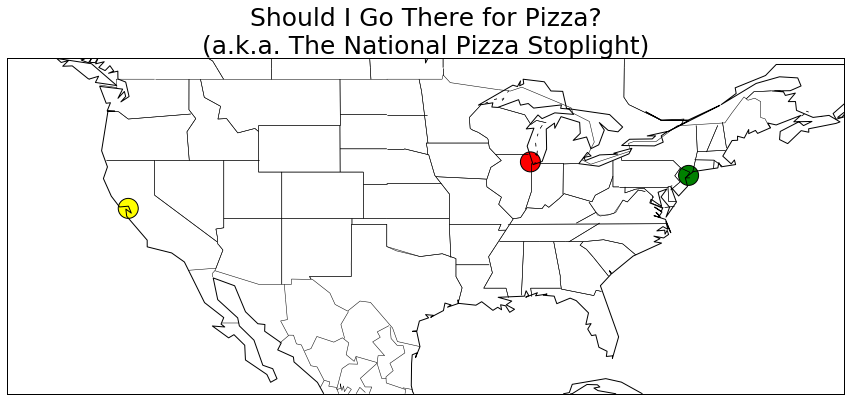

In [21]:
#We'll plug and chug, using some really basic boilerplate code 
#guilelessly stolen from Basemap's example gallery above: 

plt.figure(figsize = (15,10))

# set our lower-left and upper-right corners to whatever coordinates you got from 
# the bounding-box tool in the webpage above:
ll = (-132.7,21.9)  #THE 1ST AND 2ND PAIR OF COORDS FROM THE BBOX YOU DREW ABOVE
ur = (-60.6,50.8)

# create simplistic Basemap instance:
m = Basemap(llcrnrlon=ll[0],urcrnrlon=ur[0],\
            llcrnrlat=ll[1],urcrnrlat=ur[1])
# add coastlines, state and country borders
m.drawcoastlines()
m.drawstates()
m.drawcountries()

#plot our data on top!
colors = {'Y': 'green', '?': 'yellow', 'N':'red'}

plt.scatter(pizza['lon'], pizza['lat'],\
            c = [colors[val] for val in pizza['has_real_pizza']], s = 400)
plt.title('Should I Go There for Pizza?\n(a.k.a. The National Pizza Stoplight)', fontsize = 25)
plt.show()




---------------------------

# Combining datasets

#### Now, let's read in one each of the four major spatial data types (points, lines, polygons, and rasters)

#### We will use these to introspect common data formats. 

#### Then we'll work with them in combination, to demonstrate some common spatial operations, and hopefully give a sense for ways of thinking about the relationships among and between spatially referenced datasets.

--------------------------
## Polygons

In [9]:
#First, let's read in a simple shapefile of Bay Area cities polygons, mostly just to have a nice border for our SF plots
    #FROM: https://data.sfgov.org/Government/Bay-Area-Cities-Zipped-Shapefile-Format-/nghj-u9xk/data
    
#To do this, we will now start using GeoPandas
#It makes reading in a variety of common vector-data formats fantastically easy.
#Check it out:
cities = gpd.read_file(data_dir + 'bayarea_cities/bay_area_cities.shp')


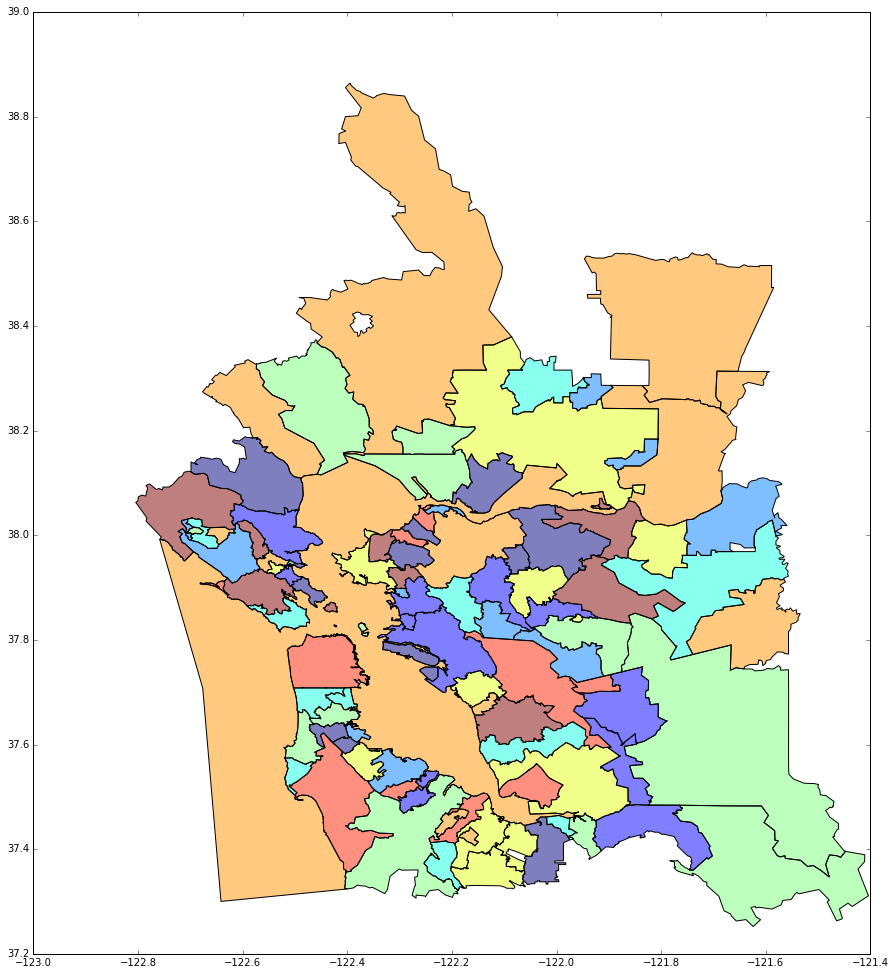

In [256]:
cities.plot(figsize = (15,25))

In [10]:
#Psychadelic.


#How do we figure out what CRS it's in?

cities.crs

{u'datum': u'NAD83',
 u'lat_0': 36.5,
 u'lat_1': 37.06666666666667,
 u'lat_2': 38.43333333333333,
 u'lon_0': -120.5,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 2000000,
 u'y_0': 500000.0000000001}

In [268]:
#But it's still a Pandas dataframe, just as we'd expect:
cities.head()

Area__             CITY       Length__  \
0  6.920507e+07          ALAMEDA   32993.210517   
1  3.979002e+08            ALAMO  157732.809744   
2  3.704884e+07           ALBANY   29800.759703   
3  1.240215e+08           ALVISO   62725.600006   
4  6.931341e+08  AMERICAN CANYON  136394.737992   

                                            geometry  
0  POLYGON ((-122.2267679873968 37.74800001236063...  
1  POLYGON ((-121.9507370008391 37.84233199803978...  
2  POLYGON ((-122.2880819998583 37.89812798807829...  
3  POLYGON ((-121.9747019992895 37.45961898989708...  
4  POLYGON ((-122.204187016854 38.20969498828558,...

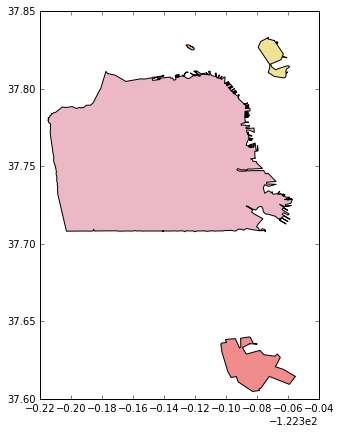

In [695]:
#And we can subset it using typical dataframe notation:

cities[cities['CITY'] == 'SAN FRANCISCO']['geometry'].plot(figsize = (5,10))

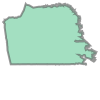

In [707]:
#So what happens if we pull out a single feature (i.e. polygon)?
test_geom = cities.geometry[106]
test_geom

In [708]:
#And how exactly is a polygon stored?

#As a Shapely Polygon object, it has an exterior attribute, within which its coordinates are stored
test_coords = test_geom.exterior.coords.xy
test_coords

(array('d', [-122.44035868528293, -122.4401799958259, -122.44041001255971, -122.44100299358438, -122.44136399439239, -122.44149300126544, -122.44210100363146, -122.44242699677064, -122.442406017737, -122.44268001661086, -122.44274001449475, -122.44299899452238, -122.44365701127145, -122.44747098622953, -122.4471819925678, -122.4424960186543, -122.44251699857396, -122.4440030024781, -122.44251699317826, -122.44251699569195, -122.44231900901983, -122.43582601523252, -122.43563299156328, -122.4342950170721, -122.43381300484987, -122.4326600069127, -122.43219499014948, -122.43264599338691, -122.43234898492159, -122.43206201789637, -122.43141400402135, -122.43178698543892, -122.43136802026777, -122.43102699407777, -122.43033301788255, -122.4306519971845, -122.43021200344123, -122.42993698743592, -122.42791702063205, -122.42698299543237, -122.42755600040459, -122.42806101452278, -122.42754399528415, -122.42672601078957, -122.42667900527852, -122.42535800585887, -122.42429999969067, -122.4246

In [709]:
#For the docs on Shapely Polygon objects:

frame('http://toblerity.org/shapely/manual.html#polygons')



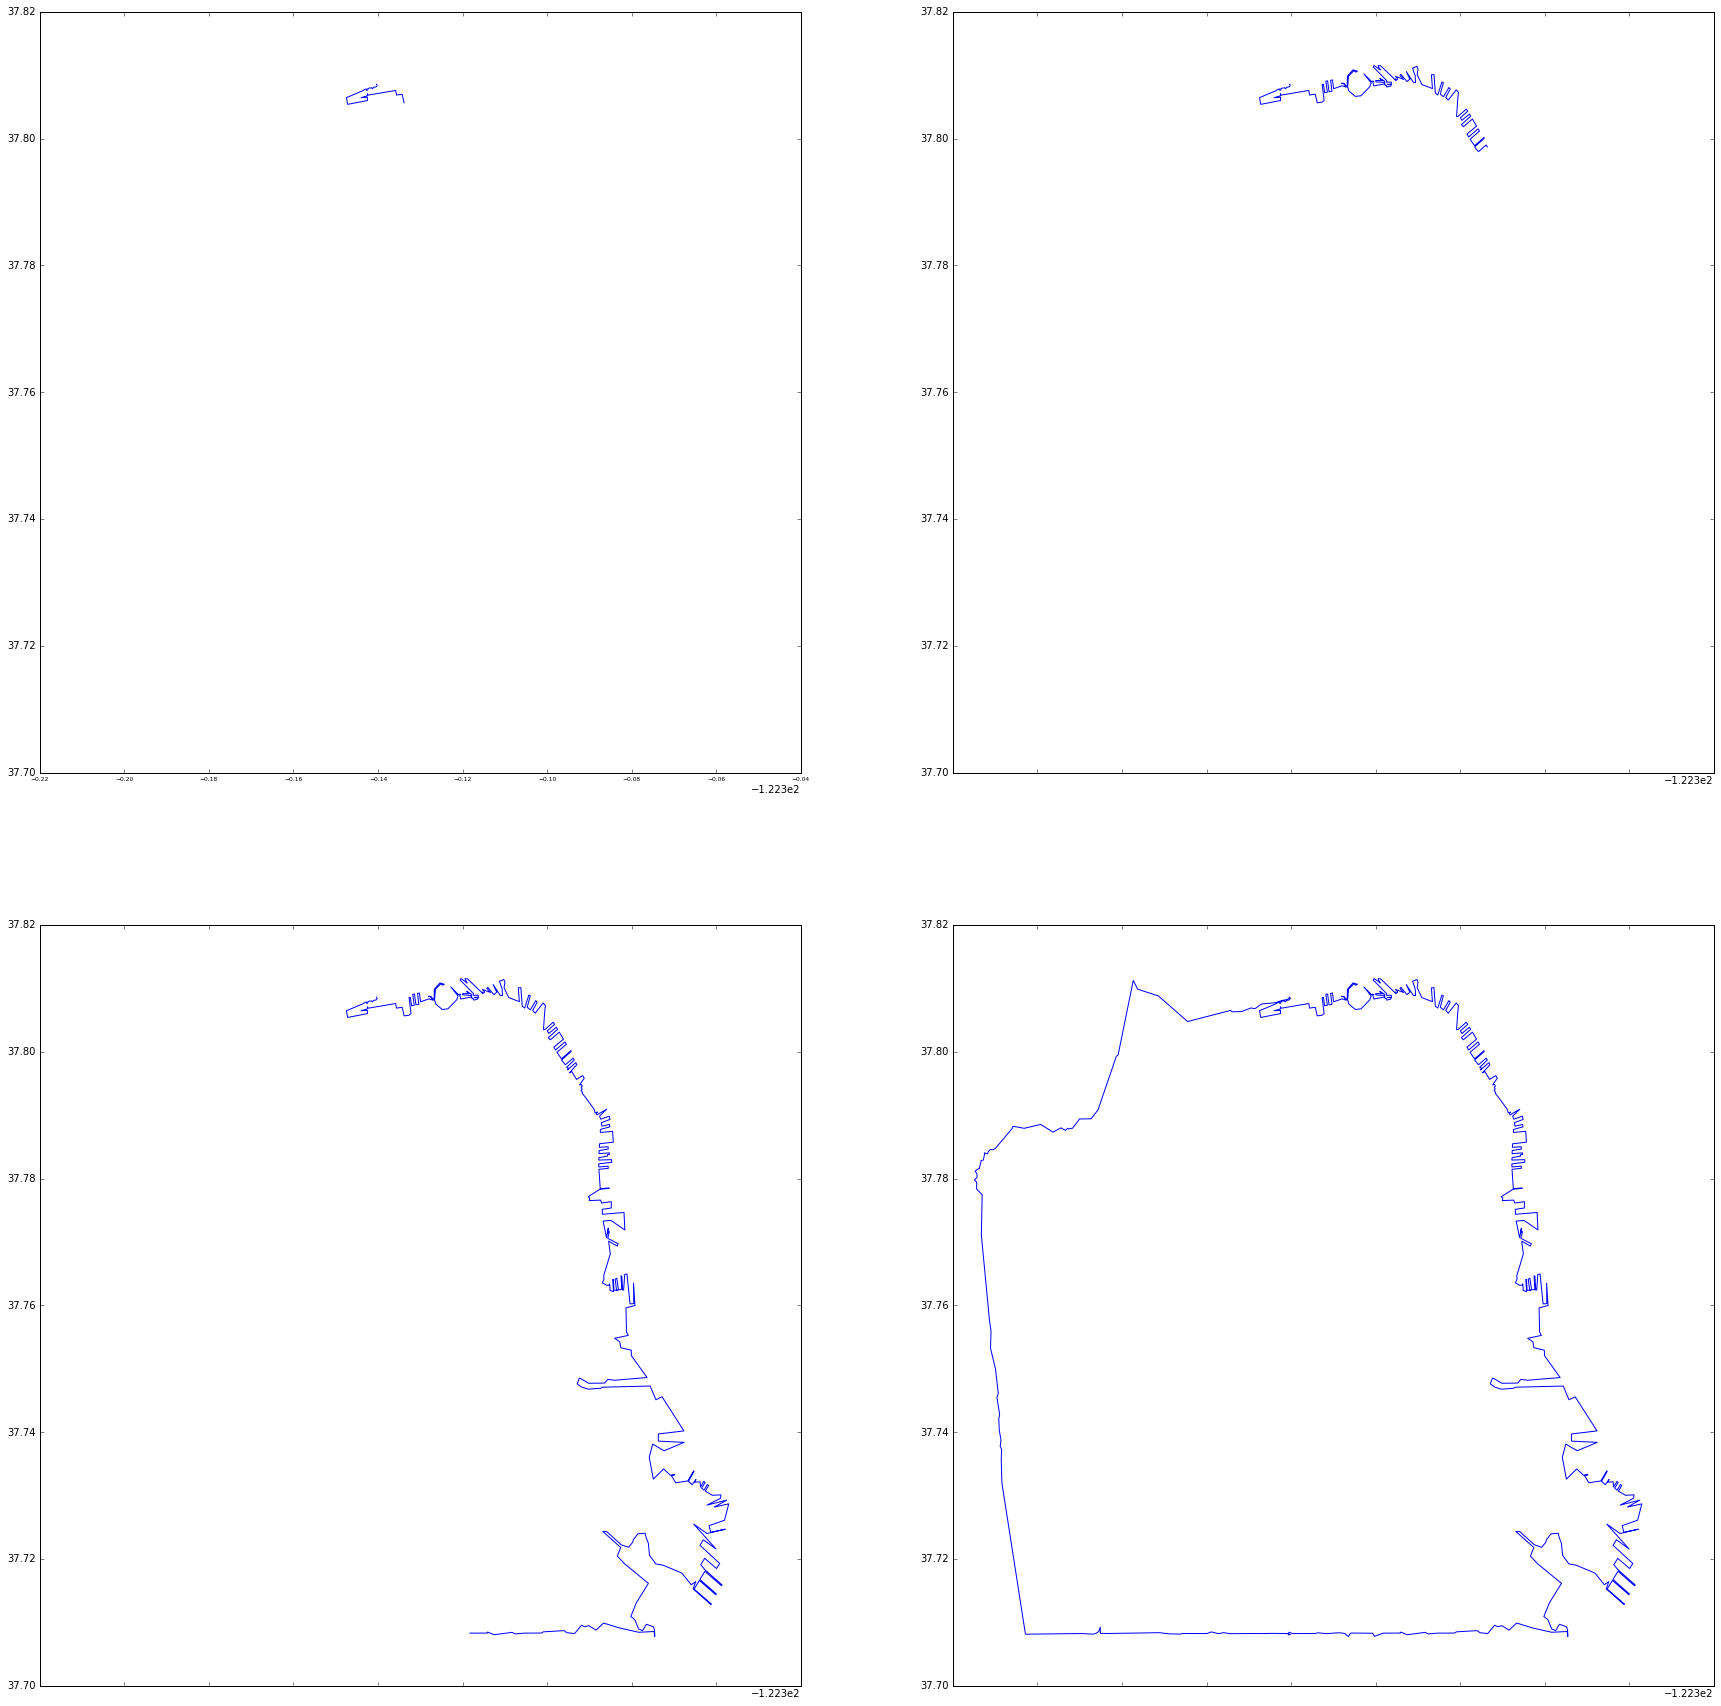

In [713]:
#So what does this all mean?...

fig, ax = plt.subplots(2,2, figsize = (30,30))

ax0 = plt.subplot(221)
plt.plot([test_coords[0][i] for i in range(25)], [test_coords[1][i] for i in range(25)])
plt.setp(ax0.get_xticklabels(), fontsize=6)

ax1 = plt.subplot(222, sharex=ax0, sharey=ax0)
plt.plot([test_coords[0][i] for i in range(150)], [test_coords[1][i] for i in range(150)])
# make these tick labels invisible
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(223, sharex=ax0, sharey=ax0)
plt.plot([test_coords[0][i] for i in range(400)], [test_coords[1][i] for i in range(400)])
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(224, sharex=ax0, sharey=ax0)
plt.plot([test_coords[0][i] for i in range(len(test_coords[0]))], [test_coords[1][i] for i in range(len(test_coords[1]))])
# make these tick labels invisible
plt.setp(ax3.get_xticklabels(), visible=False)

fig.show()

In [715]:
#In other words polygons are just "connect-the-dots", 
#with the condition that the first and last dots are the same:

(test_coords[0][0] == test_coords[0][::-1][0]) and (test_coords[1][0] == test_coords[1][::-1][0])

#NOTE: They can, however, contain interior polygons (i.e. holes), and features can also be multipolygons 
#(e.g. if they have islands)

True

--------------------------
## Points (again)

In [221]:
#POINT DATA:

#Load the SF accidents data (using Pandas, because this is just a CSV, with unprojected lat/lon coordinates)
    #FROM: https://data.sfgov.org/Public-Safety/SFPD-Incidents-from-1-January-2003/tmnf-yvry, filtered by Descript == 'TRAFFIC ACCIDENT'
acc = pd.read_csv(data_dir + 'SFPD_accidents_from_1_Jan_2003.csv')

acc.head()

IncidntNum      Category          Descript DayOfWeek        Date   Time  \
0   141066309  NON-CRIMINAL  TRAFFIC ACCIDENT    Friday  12/19/2014  17:16   
1   150124871  NON-CRIMINAL  TRAFFIC ACCIDENT   Tuesday  02/10/2015  09:26   
2   150136553  NON-CRIMINAL  TRAFFIC ACCIDENT  Saturday  02/14/2015  02:45   
3   140014301  NON-CRIMINAL  TRAFFIC ACCIDENT    Monday  01/06/2014  07:31   
4   140024811  NON-CRIMINAL  TRAFFIC ACCIDENT  Thursday  01/09/2014  09:30   

  PdDistrict      Resolution                    Address           X  \
0       PARK       UNFOUNDED      MASONIC AV / GEARY BL -122.448043   
1   RICHMOND            NONE  CALIFORNIA ST / WALNUT ST -122.448470   
2   NORTHERN  ARREST, BOOKED      POST ST / FRANKLIN ST -122.423218   
3   NORTHERN            NONE        TURK ST / LAGUNA ST -122.427206   
4    TARAVAL            NONE    LINCOLN WY / FUNSTON AV -122.470728   

           Y                               Location            PdId  
0  37.782371  (37.7823710354886, -122.448043124454)  14106630968050  
1  37.787047  (37.7870474882864, -122.448470391223)  15012487168050  
2  37.786402  (37.7864017954155, -122.423217673913)  15013655368050  
3  37.781118  (37.7811175256377, -122.427206305932)  14001430168050  
4  37.765738  (37.7657375793742, -122.470728488949)  14002481168050

In [222]:
#Create a new geometry column using the shapely.geometry.Point function
    #This is basically the simplest possible recreationg of GeoPandas' GeoDataFrame class
    #(because that class also has a bunch of additional methods/functionalities)

#Use a regular expression to grab parse the coordinates out of the strings in the "Location" column
#NOTE: These are better to use because they have much higher precision
pts = [[float(n) for n in re.findall('-?\d+\.\d+', acc.Location[i])] for i in range(len(acc))]
    
#Now convert the list of coordinates into a list of SHapely geometries, and set that as the 'geometry' column
acc['geometry'] = [Point(pts[n][1], pts[n][0]) for n, row in acc.iterrows()]

acc.head()

IncidntNum      Category          Descript DayOfWeek        Date   Time  \
0   141066309  NON-CRIMINAL  TRAFFIC ACCIDENT    Friday  12/19/2014  17:16   
1   150124871  NON-CRIMINAL  TRAFFIC ACCIDENT   Tuesday  02/10/2015  09:26   
2   150136553  NON-CRIMINAL  TRAFFIC ACCIDENT  Saturday  02/14/2015  02:45   
3   140014301  NON-CRIMINAL  TRAFFIC ACCIDENT    Monday  01/06/2014  07:31   
4   140024811  NON-CRIMINAL  TRAFFIC ACCIDENT  Thursday  01/09/2014  09:30   

  PdDistrict      Resolution                    Address           X  \
0       PARK       UNFOUNDED      MASONIC AV / GEARY BL -122.448043   
1   RICHMOND            NONE  CALIFORNIA ST / WALNUT ST -122.448470   
2   NORTHERN  ARREST, BOOKED      POST ST / FRANKLIN ST -122.423218   
3   NORTHERN            NONE        TURK ST / LAGUNA ST -122.427206   
4    TARAVAL            NONE    LINCOLN WY / FUNSTON AV -122.470728   

           Y                               Location            PdId  \
0  37.782371  (37.7823710354886, -122.448043124454)  14106630968050   
1  37.787047  (37.7870474882864, -122.448470391223)  15012487168050   
2  37.786402  (37.7864017954155, -122.423217673913)  15013655368050   
3  37.781118  (37.7811175256377, -122.427206305932)  14001430168050   
4  37.765738  (37.7657375793742, -122.470728488949)  14002481168050   

                                     geometry  
0  POINT (-122.448043124454 37.7823710354886)  
1  POINT (-122.448470391223 37.7870474882864)  
2  POINT (-122.423217673913 37.7864017954155)  
3  POINT (-122.427206305932 37.7811175256377)  
4  POINT (-122.470728488949 37.7657375793742)

In [223]:
#Now we can actually use the geometry column to convert it to a GeoPandas GeoDataFrame (a subclass of the Pandas DataFrame)
acc = gpd.GeoDataFrame(acc, geometry = acc.geometry, crs = None)

--------------------------
## Lines (and networks)

In [716]:
#We can quickly download the SF road network using a new Python package 
#(created by Geoff Boeing, a PhD candidate in urban planning here at Cal!)

frame('http://geoffboeing.com/2016/11/osmnx-python-street-networks/')



In [717]:
#Let's download the SF road network


#NOTE: NO NEED TO RUN THIS! It may take too long if we overload the wifi here, so it's fine to just watch for the
#next few cells, and then we'll be reading in an already downloaded and partially processed shapefile of this data

roads = ox.graph_from_bbox(37.837445, 37.702837, -122.300148, -122.556953, network_type='drive')
roads_proj = ox.project_graph(roads)




KeyboardInterrupt: 

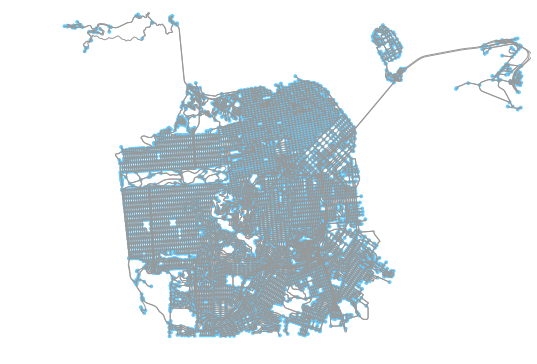

In [20]:
ax = ox.plot_graph(roads_proj)

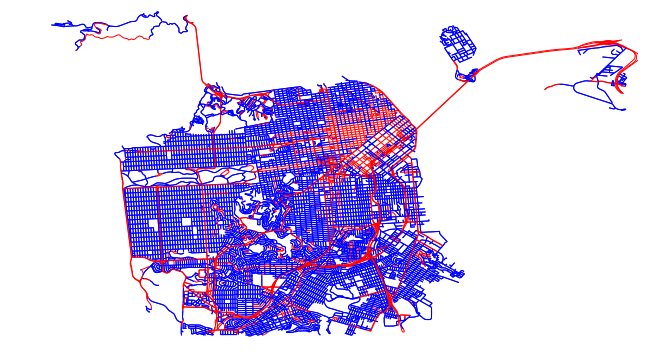

(<matplotlib.figure.Figure at 0x7fa1045e3790>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa0fd754990>)

In [35]:
#A bit of cool stuff from the Osmnx website
    #This plots one- versus two-way roads (one-way is blue)

ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec)

In [39]:
#Now, so that it's simpler to work with, let's write this out as a set of shapefiles 
#(it will write out a directory containing two subdirectories, one for the nodes shapefile, one for the edges)

ox.save_graph_shapefile(G, filename = 'roads_graph', folder = data_dir)

This warning will not be emitted anymore.


In [718]:
#... and then read it back in from the shapefile, as a GeoDataFrame

#NOTE: Here is where, if you didn't download the roads network above, you can just read this file in and move ahead

roads = gpd.read_file('/home/ihavehands/Hidden_Desktop/berk/dlab/spatial_python/practice_data/roads_graph/edges/edges.shp')

In [44]:
roads.head()

access bridge       from                                           geometry  \
0   None   None   65320121  LINESTRING (-122.4889312 37.7630516, -122.4900...   
1   None   None  258912645  LINESTRING (-122.4889312 37.7630516, -122.4890...   
2   None   None   65318518  LINESTRING (-122.4889312 37.7630516, -122.4878...   
3   None   None   65316679  LINESTRING (-122.4889312 37.7630516, -122.4888...   
4   None   None   65306641  LINESTRING (-122.4394212 37.713005, -122.44028...   

       highway key lanes         length maxspeed           name oneway  \
0  residential   0  None  94.5925998016   25 mph  Irving Street  False   
1  residential   0  None  204.590863897     None    30th Avenue  False   
2  residential   0  None  94.3899951082   25 mph  Irving Street  False   
3  residential   0  None  207.831850361     None    30th Avenue  False   
4  residential   0  None  260.367476092     None  Curtis Street  False   

       osmid   ref service        to tunnel  
0  254968950  None    None  65328470   None  
1    8918255  None    None  65328470   None  
2  254968950  None    None  65328470   None  
3    8918255  None    None  65328470   None  
4    8916910  None    None  65306635   None

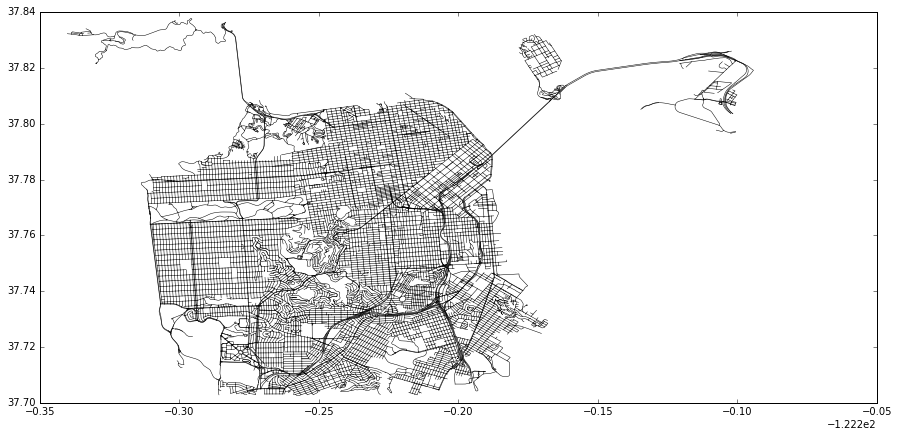

In [224]:
ax = roads.plot(color = 'black', figsize = (15,10), linewidth = 0.5)

In [46]:
#Now let's check our roads data CRS

#NOTE: Remember, we'll need to match up all of our CRS, in order to overlay combine datasets later on!

roads.crs

{'init': u'epsg:4326'}

In [11]:
#We can project our cities identically to the roads

cities = cities.to_crs(roads.crs)

In [13]:
#And project our currently unprojected accidents data, matching it to the roads

acc.crs = roads.crs
acc = acc.to_crs(roads.crs)

In [631]:
#Now, let's associate each accident with the speed limit of the road it occured on my matching each accident to the nearest road

#We'll do this is a rather quick-and-dirty way, to demonstrate the idea of a spatial intersect without getting
#bogged down in the best possible way to actually associate these accidents to their representative streets
#(in fact, probably the best way to do this would be to find the NEAREST street associated with each accident, but
#GeoPandas doesn't yet appear to have such functionality, and writing our own function would consume too much time for this course,
#so if you're interested in doing so then it's left as an independent exercise.)


#First, we'll write a function that takes a single accident coordinate, creates a small buffer around it, and
#attempts to find a single road segment that intersects with it:

def get_intsct_rds(pt, null_intsct_obj):
    buff = pt.buffer(0.00005) 
                            #NOTE: This if of course measured in our plotting units, which here is decimal degrees, and
                            #0.0005 decimal degrees is ~1.1 m N/S and ~0.8 m E/W at 45 degrees latitude, so this should give
                            #us roughly 1-meter buffers.
                            #(See table at https://en.wikipedia.org/wiki/Decimal_degrees)
                            #Hopefully this will make a lot of them intersect with their nearest
                            #roads, but not too many intersect with multiple roads.
                            #My personal trial-and-error suggested that this was the case, and that mutliply-intersecting
                            #roads are likely to be parallel, and thus likely of somewhat similar character.
                            #This should do for our deomonstrative purposes!
                            
    intsct = roads['geometry'].intersection(buff)
    intsct_rds = [n for n, i in enumerate(intsct) if not i == null_intsct_obj]
    
    return(intsct_rds)


In [632]:
#Pull the comparison between the first accident point and the first road segment, which do not intersect,
#as a comparative for testing the condition that a particular road segment DOES intersect with an accident buffer
null = get_intsct_road(acc.ix[0]['geometry'])[0]
print(null)

GEOMETRYCOLLECTION EMPTY


In [633]:
#A function to return the road segment ID for an intersecting road, iff there is only one road segment that intersects
def return_intsct_rd_info(intsct_rds):
    
    
    #Try to go through and get the first intersecting road segment for each accident point
    #try:
    #print('-----------------------------')
    print('Intersected with %i road segments.\n\n' % len(intsct_rds))

    if len(intsct_rds) > 0:
        #Just making the heroic assumption that it is OK to use the first road of the intsct_rds list, even if there are multiples
        intsct_id = intsct_rds[0]

        print('intsct_id = %i\n\n' % intsct_id)

        intsct_row = roads.ix[intsct_id]

        #print(intsct_row['maxspeed'])

        #intsct_mph = int(intsct_row['maxspeed'].values[0].rstrip(' mph')
        intsct_mph = intsct_row['maxspeed']

        #print(intsct_mph)

        intsct_hwy = intsct_row['highway']

        #print(intsct_hwy)



        return(intsct_id, intsct_mph, intsct_hwy, len(intsct_rds))
    else:
        return(tuple([None]*4))
    
    

In [634]:
#Now, a single function to implement the two above, accepting a row as the only argument:

def find_intsct_road_info(row):
    
    print('<<<<<<<<<<<<<>>>>>>>>>>>>>\n')
    print('ROW: %s\n\n' % str(row.name))
    
    res = return_intsct_rd_info(get_intsct_rds(row['geometry'], null_intsct_obj = null))
    
    #print(res)
    return(res)
                                

In [635]:
#And now we can apply this accross all of our accident data

#NOTE: We're actually only going to run this for the first ten rows, because it takes a while.
#Then we'll read in a new version of the accidents data that has this new data added to it.

res = acc.ix[1:10].apply(find_intsct_road_info, axis = 1)



$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 0
1
15111
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 1
3
853
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 2
4
5685
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 3
4
1592
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 4
4
1016
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 5
4
10247
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 6
4
5690
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 7
4
8363
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 8
4
545
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 9
3
2369
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 10
4
10782
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 11
1
15235
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 12
4
3796
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 13
4
11712
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 14
4
10599
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 15
4
14142
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 16
1
7791
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 17
1
8700
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 18
4
9854
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 19
4
7772
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 20
5
5468
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 21
3
4220
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 22
4
2293
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 23
4
7890
$$$$$$$$$$$$$$$$$$$$$$$$
ROW: 24
3
9718
$$$$$

In [729]:
save_acc.head()

IncidntNum      Category          Descript DayOfWeek        Date   Time  \
0   141066309  NON-CRIMINAL  TRAFFIC ACCIDENT    Friday  12/19/2014  17:16   
1   150124871  NON-CRIMINAL  TRAFFIC ACCIDENT   Tuesday  02/10/2015  09:26   
2   150136553  NON-CRIMINAL  TRAFFIC ACCIDENT  Saturday  02/14/2015  02:45   
3   140014301  NON-CRIMINAL  TRAFFIC ACCIDENT    Monday  01/06/2014  07:31   
4   140024811  NON-CRIMINAL  TRAFFIC ACCIDENT  Thursday  01/09/2014  09:30   

  PdDistrict      Resolution                    Address           X  \
0       PARK       UNFOUNDED      MASONIC AV / GEARY BL -122.448043   
1   RICHMOND            NONE  CALIFORNIA ST / WALNUT ST -122.448470   
2   NORTHERN  ARREST, BOOKED      POST ST / FRANKLIN ST -122.423218   
3   NORTHERN            NONE        TURK ST / LAGUNA ST -122.427206   
4    TARAVAL            NONE    LINCOLN WY / FUNSTON AV -122.470728   

           Y                               Location            PdId  \
0  37.782371  (37.7823710354886, -122.448043124454)  14106630968050   
1  37.787047  (37.7870474882864, -122.448470391223)  15012487168050   
2  37.786402  (37.7864017954155, -122.423217673913)  15013655368050   
3  37.781118  (37.7811175256377, -122.427206305932)  14001430168050   
4  37.765738  (37.7657375793742, -122.470728488949)  14002481168050   

                                     geometry  intsct_id  intsct_mph  \
0  POINT (-122.448043124454 37.7823710354886)    15111.0        35.0   
1  POINT (-122.448470391223 37.7870474882864)      853.0         NaN   
2  POINT (-122.423217673913 37.7864017954155)     5685.0         NaN   
3  POINT (-122.427206305932 37.7811175256377)     1592.0         NaN   
4  POINT (-122.470728488949 37.7657375793742)     1016.0         NaN   

    intsct_hwy  num_buff_matches  
0      primary               1.0  
1    secondary               3.0  
2     tertiary               4.0  
3  residential               4.0  
4  residential               4.0

In [638]:
res

0      (15111, 35 mph, primary, 1)
1        (853, None, secondary, 3)
2        (5685, None, tertiary, 4)
3     (1592, None, residential, 4)
4     (1016, None, residential, 4)
5      (10247, 25 mph, primary, 4)
6     (5690, 25 mph, secondary, 4)
7     (8363, None, residential, 4)
8    (545, 25 mph, residential, 4)
9     (2369, 30 mph, secondary, 3)
dtype: object

In [683]:
#Now we can format and add these new columns to our accidents data

#NOTE: This will not actually run for us right now, as we didn't spend the time to get roads data for all 997 accidents points

speed_patt = re.compile('\d+')

acc['intsct_id'] = [i[0] if i[0] is not None else np.NaN for i in res]
#acc['intsct_mph'] = [re.search(speed_patt, i[1]).group() if i[1] is not None else np.NaN for i in res]
acc['intsct_mph'] = [int(re.search(speed_patt, res[i][1]).group()) if res[i][1] is not None else np.NaN for i in range(len(res))]
acc['intsct_hwy'] = [i[2] if i[2] is not None else np.NaN for i in res]
acc['num_buff_matches'] = [i[3] if i[3] is not None else np.NaN for i in res]

In [757]:
#Write the resulting data to file

#NOTE: Same as above, this won't run for us now. We'll read in the shapefile that resulted from this in the next cell

acc.to_csv(data_dir + 'accident_data_with_road_intsct_data.csv', index = False, sep = '|')

In [753]:
#Read in the pre-saved accidents data after adding the intersected roads data to it

#NOTE: I had to save it as a CSV because Geopandas was throwing some bizarre errors about writing it to a shapefile
#that seemed to me like they might be caused by bugs. Remember, we're working with very actively developed software...

new_acc = pd.read_csv(data_dir + 'accident_data_with_road_intsct_data.csv', sep = '|')
new_acc['geometry'] = new_acc.apply(lambda x: Point([float(i) for i in re.findall('-?\d+[.]\d+', x['geometry'])]), axis = 1)
new_acc = gpd.GeoDataFrame(new_acc)
new_acc.crs = roads.crs
acc = new_acc.to_crs(roads.crs)
acc.head()


IncidntNum      Category          Descript DayOfWeek        Date   Time  \
0   141066309  NON-CRIMINAL  TRAFFIC ACCIDENT    Friday  12/19/2014  17:16   
1   150124871  NON-CRIMINAL  TRAFFIC ACCIDENT   Tuesday  02/10/2015  09:26   
2   150136553  NON-CRIMINAL  TRAFFIC ACCIDENT  Saturday  02/14/2015  02:45   
3   140014301  NON-CRIMINAL  TRAFFIC ACCIDENT    Monday  01/06/2014  07:31   
4   140024811  NON-CRIMINAL  TRAFFIC ACCIDENT  Thursday  01/09/2014  09:30   

  PdDistrict      Resolution                    Address           X  \
0       PARK       UNFOUNDED      MASONIC AV / GEARY BL -122.448043   
1   RICHMOND            NONE  CALIFORNIA ST / WALNUT ST -122.448470   
2   NORTHERN  ARREST, BOOKED      POST ST / FRANKLIN ST -122.423218   
3   NORTHERN            NONE        TURK ST / LAGUNA ST -122.427206   
4    TARAVAL            NONE    LINCOLN WY / FUNSTON AV -122.470728   

           Y                               Location            PdId  \
0  37.782371  (37.7823710354886, -122.448043124454)  14106630968050   
1  37.787047  (37.7870474882864, -122.448470391223)  15012487168050   
2  37.786402  (37.7864017954155, -122.423217673913)  15013655368050   
3  37.781118  (37.7811175256377, -122.427206305932)  14001430168050   
4  37.765738  (37.7657375793742, -122.470728488949)  14002481168050   

                                     geometry  intsct_id  intsct_mph  \
0  POINT (-122.448043124454 37.7823710354886)    15111.0        35.0   
1  POINT (-122.448470391223 37.7870474882864)      853.0         NaN   
2  POINT (-122.423217673913 37.7864017954155)     5685.0         NaN   
3  POINT (-122.427206305932 37.7811175256377)     1592.0         NaN   
4  POINT (-122.470728488949 37.7657375793742)     1016.0         NaN   

    intsct_hwy  num_buff_matches  
0      primary               1.0  
1    secondary               3.0  
2     tertiary               4.0  
3  residential               4.0  
4  residential               4.0

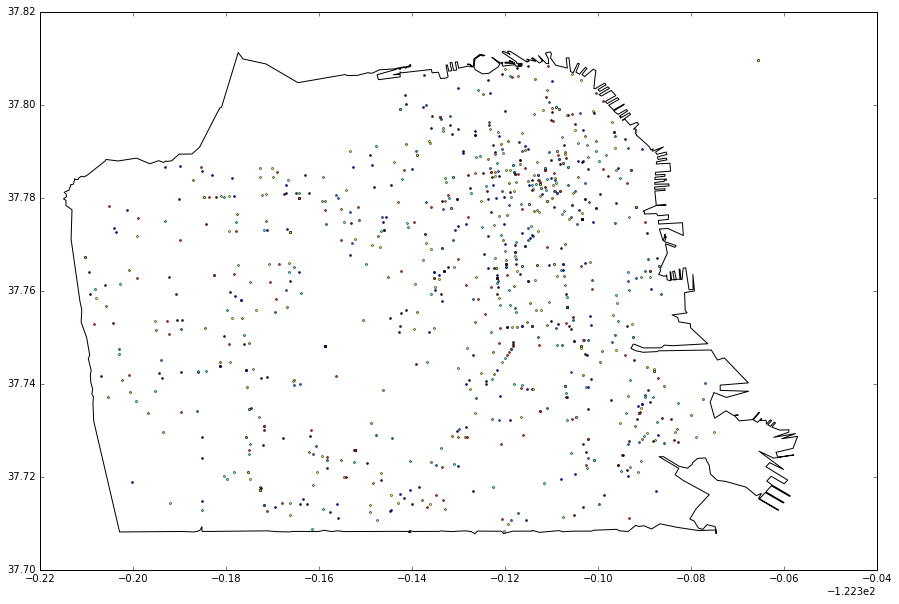

In [756]:
#Check that the plotting still seems to work out all right

ax = cities.ix[106:106].plot(color = 'white', figsize = (15,15))
acc.plot(ax = ax)

In [762]:
#Now, how many rows have MPH data?
len(acc.dropna(axis = 0, subset = ['intsct_mph']))

235

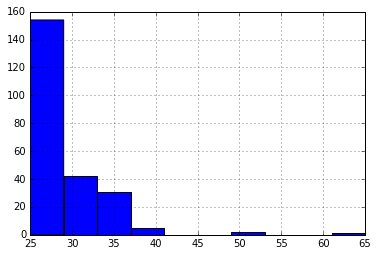

In [691]:
#Where are the most accidents occurring?
acc['intsct_mph'].hist()

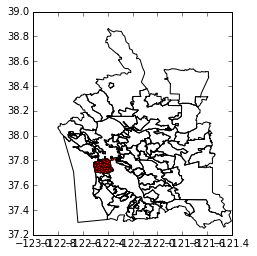

In [257]:
#Geopandas discusses two ways to plot layers:

################################

#1.) Using geopandas functions alone (quicker, but less flexible)
base = cities.plot(color = '#ffffff')
roads.plot(ax = base, color = 'black', figsize = (15,10))
acc.plot(ax = base, marker = 'o', color = 'red', figsize = (15,25))

#Not really nice, especially given that our shapefiles' extensions don't line up...


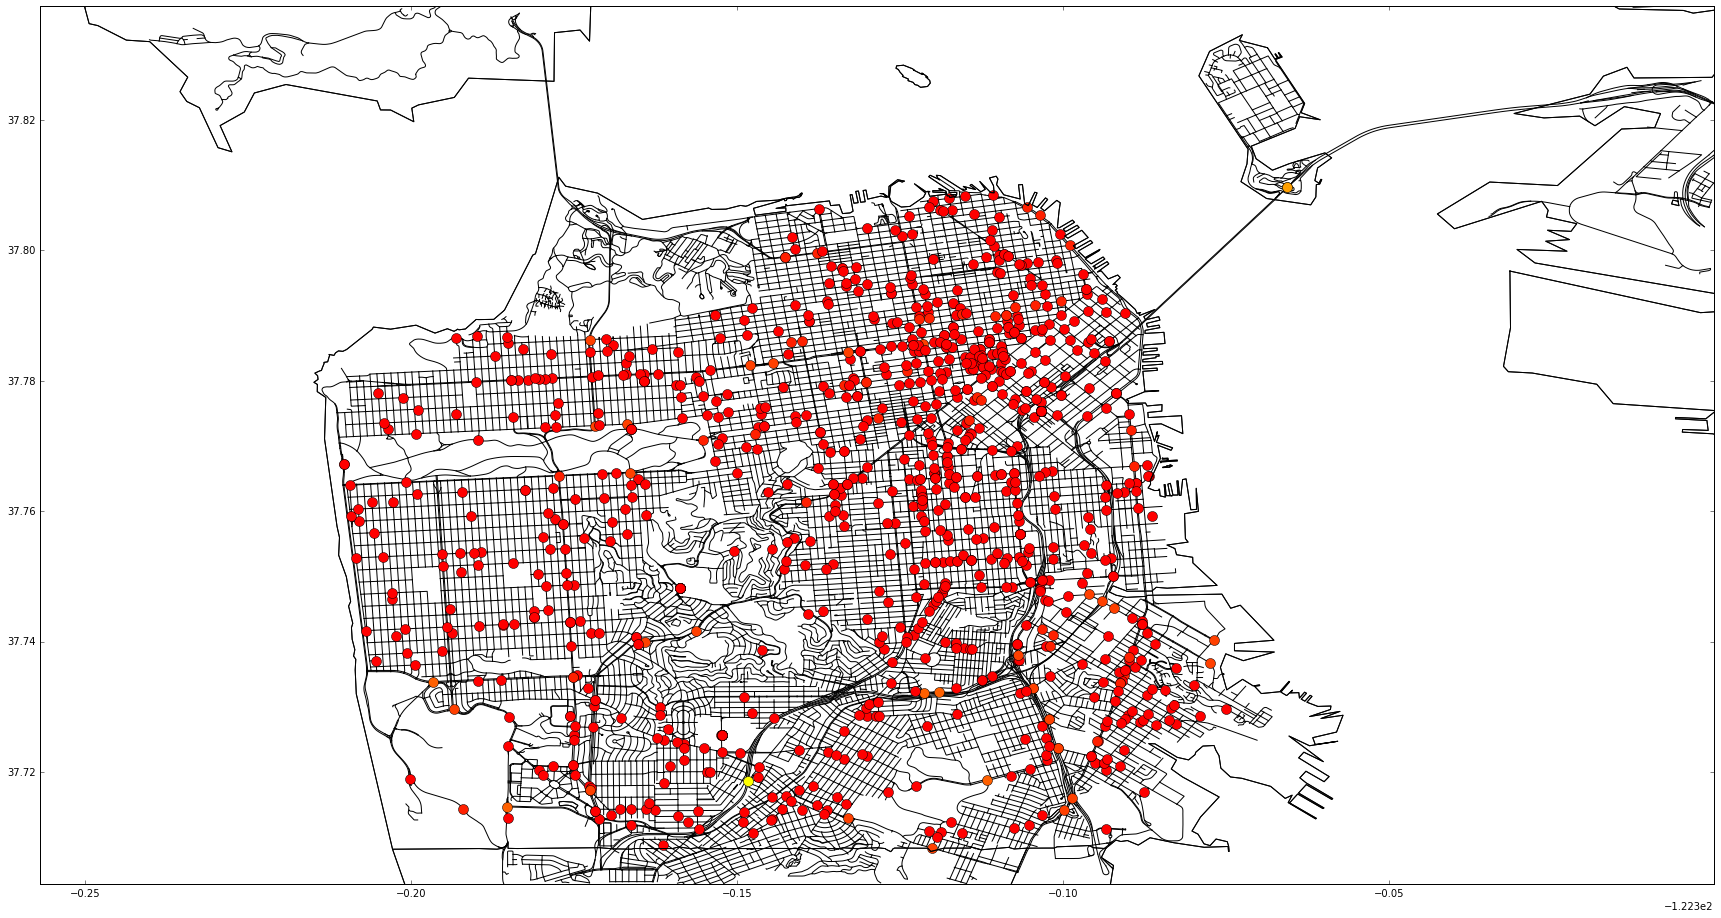

In [806]:
################################

#Or 2.) We can plot this all together using matplotlib
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (30,30))

# FROM GEOPANDAS WEBSITE:
    #Set aspect to equal. This is done automatically
    # when using Geopandas to plot on it's own, but needs
    # to be done manually when working with pyplot directly.
ax.set_aspect('equal')

ax.set_ylim([37.702837, 37.83744])         #Remember, we got these from our bounding-box website
ax.set_xlim([-122.556953, -122.300148])


roads.plot(ax=ax, color='black', figsize = (20,15))

acc.plot(ax=ax, column = 'intsct_mph', cmap = 'Reds', markersize = 10, marker = 'o')

cities.plot(ax=ax, color='white', alpha = 0.5)


plt.show();


#NOTE: THIS WILL TAKE A COUPLE OF MINTUES. 
    #Meanwhile, any questions?


--------------------------
## Rasters

In [693]:
#To read in and work with raster data, we'll be using Python's GDAL ('Geospatial Data Abstraction Library') package.
#gdal is a third-party library that predominates in the open-source geospatial world, and this Python package
#provides wrappers (i.e. an API) around it.

#It is admittedly not very high level at all, and the documentation is not very fancy or easy to work with, as it is
#mostly a set of references to gdal stuff. Here's the website:

frame('http://gdal.org/python/')


In [339]:
#And here's the website to the gdal library (i.e. NOT the Python package) itself, with the source for more detailed 
#information about the data models, formats, etcetera

frame('http://gdal.org/')

In [378]:
#Load a SF DEM (Digital Elevation Model) raster
    #FROM http://bard.wr.usgs.gov/getDEMSMap.html
    #Downloaded pt_bonita.dem  sf_north.dem  sf_south.dem  sf_south_oe.dem
    #Used gdal_merge.py, a standalone Python script tool from GDAL, to make mosaic (http://www.gdal.org/gdal_merge.html)
 
elev = gdal.Open(data_dir + '/warped_clipped_DEM.tif', gdal.GA_ReadOnly) 


#NOTE: CLIPPED refers to the fact that I clipped a much larger raster file to the extent of SF
      #WARPED refers to the fact that I reprojected the raster so that it would automatically match our shapefiles when
      #we read it in (because it's like a quilt with even-sized patches, think of an elastic-y quilt that gets cut from
      #the side of a globe; then think of stretch it over a different projection object instead (e.g. cylinder), and
      #imagine what happens to each of the quilt patches...).
      #This is because reprojecting rasters manually in Python was well outside the bounds of this class.


In [379]:
#I already set the projection to match our working EPSG:4326 projection, when I was prepping the raster layer
elev.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [380]:
#What does raster data look like exactly?

#Let's grab just the data, as a numpy array
array = elev.GetRasterBand(1).ReadAsArray()

#NOTE: We can think of 'bands' as layers of the raster array. For example, for remote-sensing data in RGB, there are
#3 bands (R, G, and B).
#Because we're using a DEM, we should have just a single band, containing our z (elevation) values


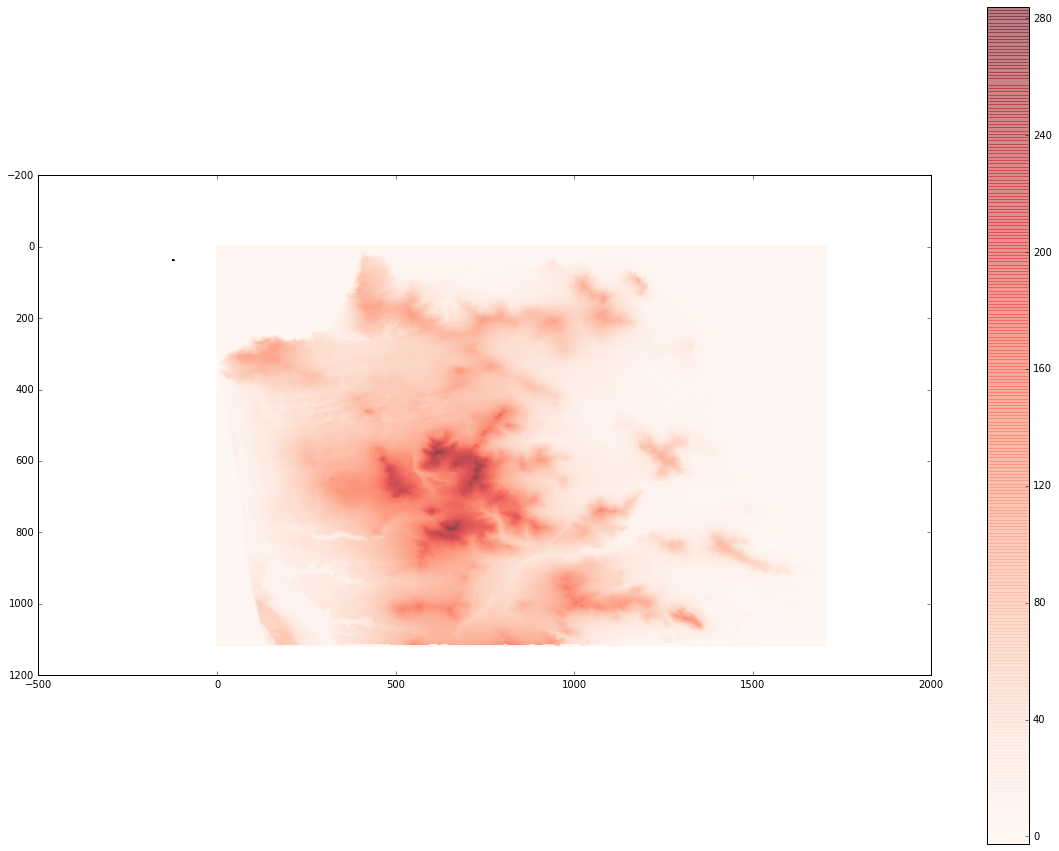

In [381]:
#Then plot it
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,15))
ax.add_image(plt.imshow(array, cmap = 'Reds', alpha = 0.5))   #NOTE: Matplotlib colormaps are nicely laid out here: http://matplotlib.org/users/colormaps.html
plt.colorbar()
cities.plot(ax = ax)
fig.show()

In [445]:
#What happened?

#Check out the axes. Even though our GeoTiff is projected (and I made sure it was in the same projection when
#preparing it for the course), the raster object doesn't have a nice, clean method like GeoPandas' gdf.plot()
#method. So we've just plotted the raster's array, and the axes are simply its indices.


#We'll have to mess with numpy, matplotlib, and basemap in order to plot our raster object...


#We can return our GeoTransform object, which will be a list containing:
    # top left x 
    # w-e pixel resolution 
    # rotation (0 if image is "north up")
    # top left y 
    # rotation (0 if image is "north up")
    # n-s pixel resolution 
    
gt = elev.GetGeoTransform()

#And then set up some important information using it, including:

#Spatial resolution on each axis
xres = gt[1]
yres = gt[5]

#And raster size on each axis
x_sz = elev.RasterXSize
y_sz = elev.RasterYSize

#Our min and max coordinates (which we need to set to the centers of the lower-left and upper-right cells,
#using 0.5 * our resolutions and our lower-right corner coordinates
xmin = gt[0] + (xres * 0.5)
xmax = gt[0] + (xres * x_sz) - xres * 0.5
ymin = gt[3] + (yres * y_sz) - yres * 0.5
ymax = gt[3] - yres * 0.5





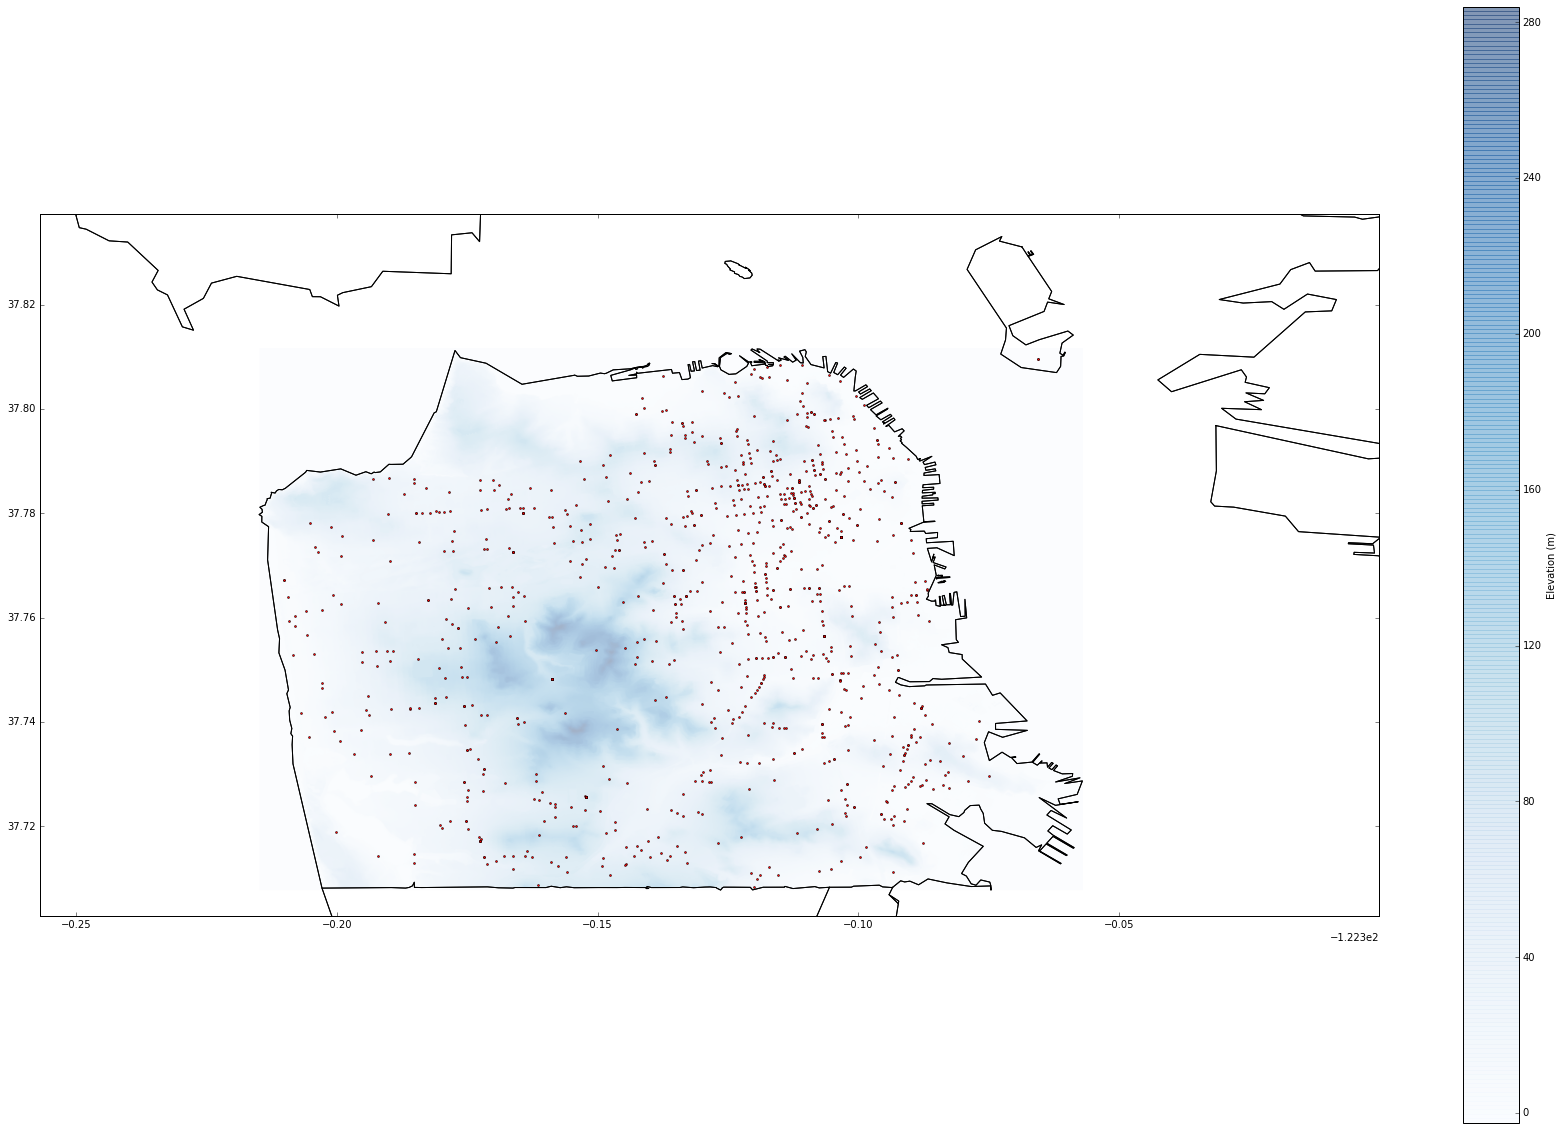

In [345]:
#Now we can try our map out again:

#Create figure and axes
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (30,20))

#Set axis limits
ax.set_ylim([37.702837, 37.83744])
ax.set_xlim([-122.556953, -122.300148])

#Now add our image using the min and max x and y values that we calculated
ax.add_image(plt.imshow(array, cmap = 'Blues', alpha = 0.5, extent = (xmin, xmax, ymin, ymax)))   #NOTE: Matplotlib colormaps are nicely laid out here: http://matplotlib.org/users/colormaps.html

#Add a perty colorbar (elevations are in meters, FYI)
plt.colorbar(label = 'Elevation (m)')

cities.plot(ax = ax, color = 'white')

acc.plot(ax = ax, color = 'red')

#roads.plot(ax = ax, color = 'black', linewidth = 0.5) #NOTE: OVERWHLEMED MY LAPTOP

fig.show()

plt.savefig('./accidents_map.pdf')

In [363]:
#Now, let's say we're curious if the steepness of a street predicts the likelihood of an accident, 
#after controlling for highway type and speed limit

#We can test this!
#First we'll need to calculate the finite-difference approximation of the slopes (in both x and y directions) for 
#all of our raster cells.

#Here are a few functions that, together, will allow us to do this
#(a la http://pangea.stanford.edu/~samuelj/musings/dems-in-python-pt-3-slope-and-hillshades-.html):

def calcFiniteSlopes(elev_grid, dx):
    # calculates finite differences in X and Y directions using the 
    # 2nd order/centered difference method.
    # Applies a boundary condition such that the size and location 
    # of the grids in is the same as that out.
        #NOTE: The output grid would otherwise be 2 smaller in each dimension than the input
        #becuase of the fact that we take the difference between vectors shifted by 2 indices
        #relative to one another

    # Assign boundary conditions
    Zbc = assignBCs(elev_grid)

    #Compute finite differences
    Sx = (Zbc[1:-1, 2:] - Zbc[1:-1, :-2])/(2*dx)
    Sy = (Zbc[2:,1:-1] - Zbc[:-2, 1:-1])/(2*dx)

    return Sx, Sy



def assignBCs(elevGrid):
    # Boundary condition pads the boundaries with equivalent values 
    # to the data margins, e.g. x[-1,1] = x[1,1]
    # This creates a grid 2 rows and 2 columns larger than the input

    ny, nx = elevGrid.shape  # Size of array
    Zbc = np.zeros((ny + 2, nx + 2))  # Create boundary condition array
    Zbc[1:-1,1:-1] = elevGrid  # Insert old grid in center

    #Assign boundary conditions - sides
    Zbc[0, 1:-1] = elevGrid[0, :]
    Zbc[-1, 1:-1] = elevGrid[-1, :]
    Zbc[1:-1, 0] = elevGrid[:, 0]
    Zbc[1:-1, -1] = elevGrid[:,-1]

    #Assign boundary conditions - corners
    Zbc[0, 0] = elevGrid[0, 0]
    Zbc[0, -1] = elevGrid[0, -1]
    Zbc[-1, 0] = elevGrid[-1, 0]
    Zbc[-1, -1] = elevGrid[-1, 0]

    return Zbc



def calc_slope_mag(elev_grid, dx):
    
    #Calculate a single slope magnitude for each cell, using Pythagorean theorem
    Sx, Sy = calcFiniteSlopes(elev_grid, dx)
    S_mag_radians = np.arctan(np.sqrt(Sx**2 + Sy**2))  # magnitude of slope in radians
    return(S_mag_radians)

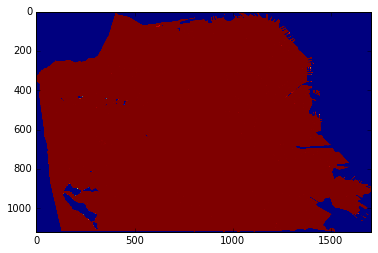

In [391]:
slope = calc_slope_mag(array, elev.GetGeoTransform()[1])
plt.imshow(slope)

In [392]:
#What happened!?!

#Because our DEM is in decimal degrees, but elevation is in meters, it is (clearly) totally meaningless to
#use it as is to calculate slope. In fact, essentially all cells have very steep slopes of nearly 100%, because
#even a change of 0.1 m elevation between cells that are only 9.25e-05 degrees apart are returns nearly vertical 
#slopes (i.e. angles ~ pi/2 radians = ~ 1.57 radians)

np.arctan(np.sqrt((10e-1/10e-5)**2 + (10e-1/10e-5)**2))


1.5707256161168959

In [393]:
#So, to do this right, we would need to convert our DEM CRS to UTM, assigning it the correct UTM zone,
#so that all three directions are in meters, and then calculate slope using that layer.

#HOWEVER, instead of spending the time to do that, and in the interest of moving right along with the conceptual demo
#let's just quickly (and VERY ROUGHLY; this would NEVER be acceptable outside the bounds of a purely demonstrative 
#conceptual exercise) 'convert' ours to a common unit by estimating the distance in decimal degrees/meter, then 
#multiplying all of our z values by that rate. #Remember, this will still provide roughly accurate slope 
#estimations for each cell, that will be just as interpretable as otherwise, because slope winds up in radians either way.

#The Wikipedia table of decimal degree lengths provides some dec deg-length equivalents that we can use to 
#calculate a rough relationship: https://en.wikipedia.org/wiki/Decimal_degrees

dec_deg_per_m = 1/(((102.47+78.71)/2+111.32)/2*1000) 
    #1/(avg of (avg of E/W distances of 1 dec deg at 23 and 45 degrees latitude) and N/S distance of 1 dec deg)

corrected_array = array*dec_deg_per_m
corrected_slope = calc_slope_mag(corrected_array, elev.GetGeoTransform()[1])

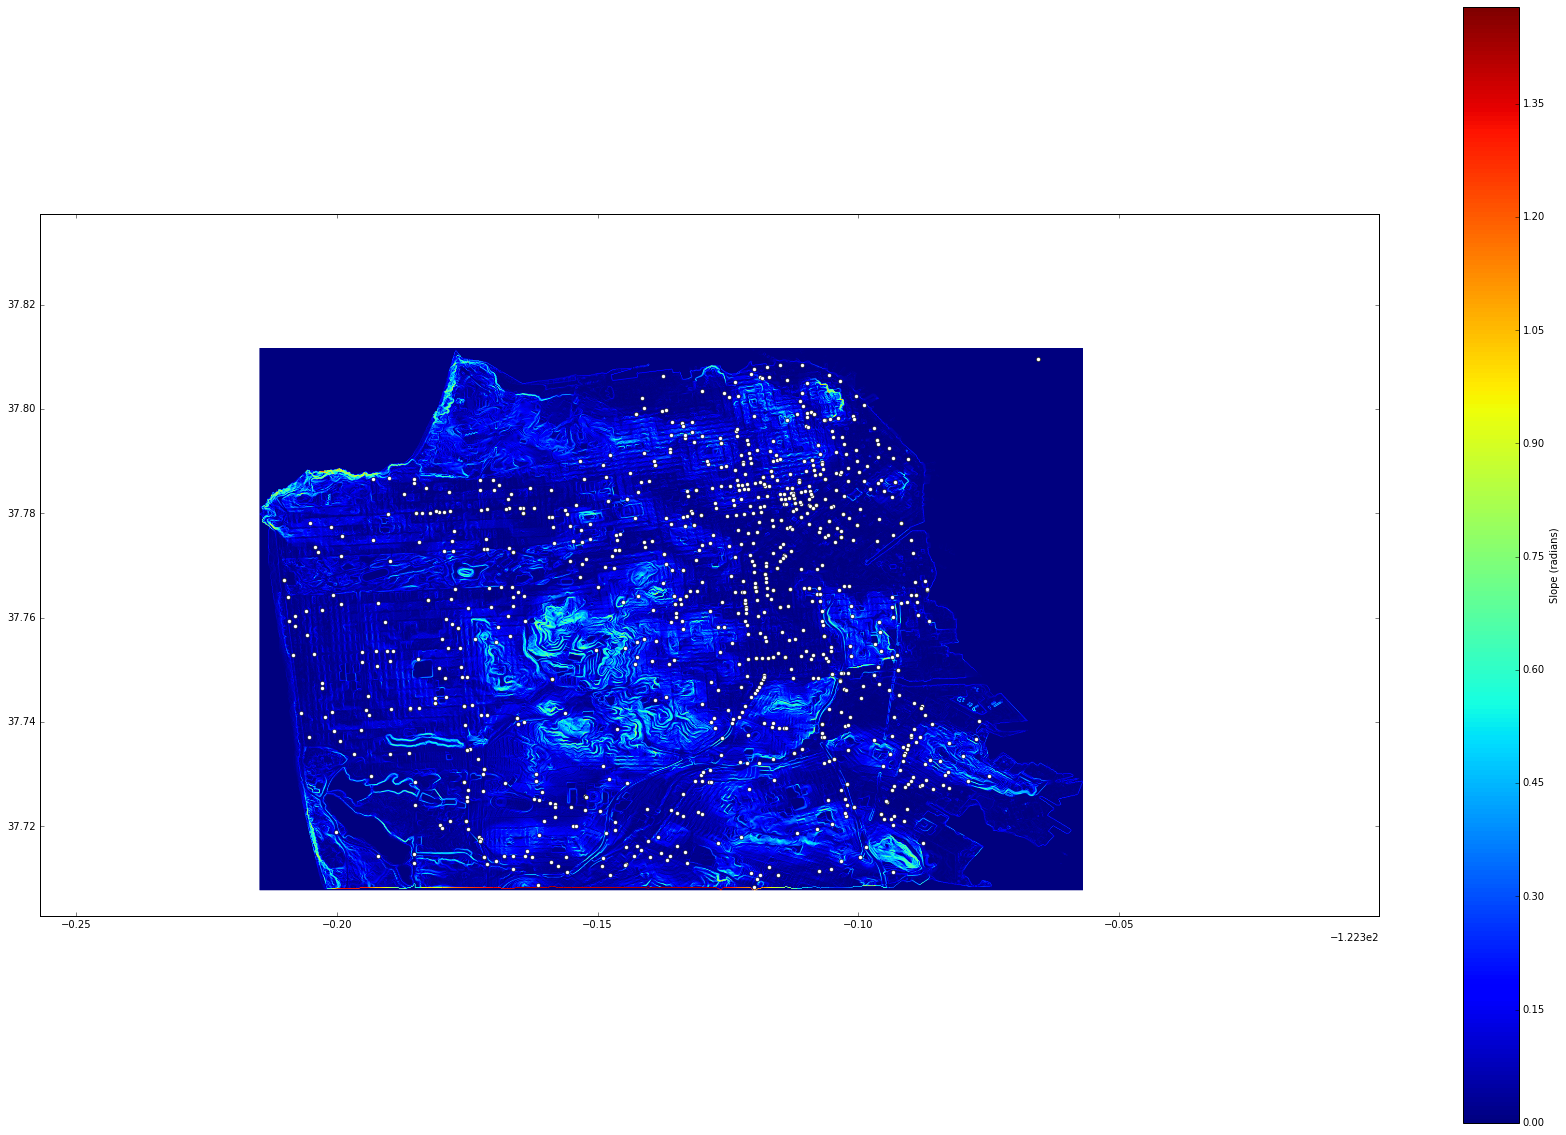

In [454]:
#Here's the corrected slope raster
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (30,20))

ax.set_ylim([37.702837, 37.83744])
ax.set_xlim([-122.556953, -122.300148])

ax.add_image(plt.imshow(corrected_slope, extent = (xmin, xmax, ymin, ymax)))
plt.colorbar(label = "Slope (radians)")

acc.plot(ax = ax, color = 'white', marker = 'o', markersize = 8)

fig.show()

#Notice the clearly incorrect edge effects at the SF/Daly City border. To my knowledge, there is not a sheer 
#cliff separating the two. Instead, this results from the fact that I clipped the raster to the extent of
#SF's boundary, so at those cells on the boundary the elevation artificially jumps from the actual elevation
#there to 0 meters one cell further south.


In [765]:
#Now we'd like to extract to a new column in our accidents data 
#the slope of the cell which that accident occurred
#(again, recognizing that we will be doing this in a simplified but conceptually satisfying way,
#to make it fit the demands of our class)


#We can do this by subtracting the coordinates of a point from the minimum coordinates of the raster,
#then dividing the result by the raster cell size (i.e. interval between two cells), and taking the floor


#Set the raster x_min and y_min (remember, not quite the same as our plotting mins, because those were the cell
#centers, whereas here we're concerned with the ll corners)
rast_xmin = gt[0]
rast_ymin = gt[3] + (yres * y_sz)


#Then definie a function that will extract the corresponding raster value for each point
def extract_rast_val(point, rast):
    try:
        
        x = int(np.floor((point.coords.xy[0][0]-rast_xmin)/xres))
    
        y = int(np.floor((point.coords.xy[1][0]-rast_ymin)/xres))
        
        slope = rast[y,x] #NOTE: Raster is indexed by i, j (which corresponds to y, x)
    except Exception:
        slope = np.NaN
    
    return(slope)

In [766]:
#Now we apply that function across our dataframe's rows

acc_slope = acc.apply(lambda x: extract_rast_val(x['geometry'], corrected_slope), axis = 1)

In [767]:
#And then set that as a column, 'slope', in our accidents dataframe

acc['slope'] = acc_slope

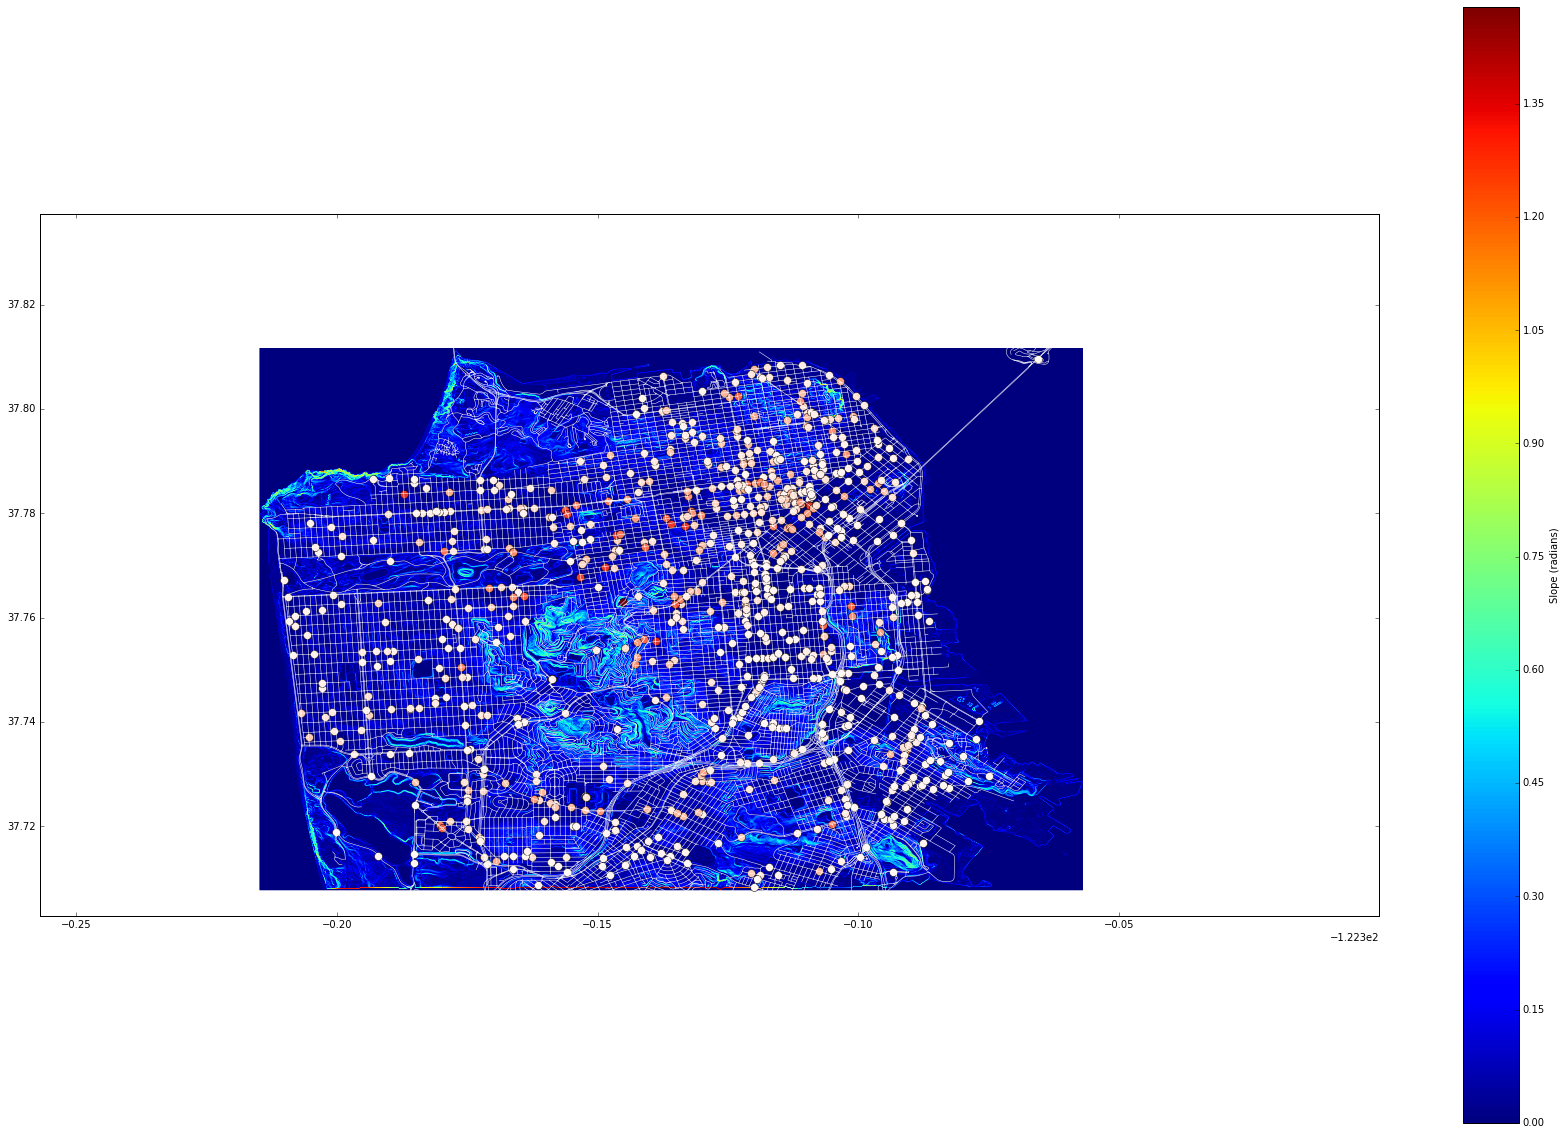

In [809]:
#And here's the corrected slope raster, with accidents labeled by slope
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (30,20))

ax.set_ylim([37.702837, 37.83744])
ax.set_xlim([-122.556953, -122.300148])

ax.add_image(plt.imshow(corrected_slope, extent = (xmin, xmax, ymin, ymax)))
plt.colorbar(label = "Slope (radians)")

cities.plot(ax = ax, color = 'white', linewidth = 1.5)

roads.plot(ax = ax, color = 'white', linewidth = 0.5)

acc.plot(ax = ax, column = 'slope', cmap = 'Reds', marker = 'o', markersize = 8)

fig.show()

plt.savefig('./accidents_slope_map.pdf')


(array([ 389.,  196.,  123.,   79.,   45.,   45.,   26.,   21.,   15.,
          21.,    7.,    5.,    6.,    6.,    2.,    6.,    4.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 0.        ,  0.03410894,  0.06821788,  0.10232682,  0.13643576,
         0.17054471,  0.20465365,  0.23876259,  0.27287153,  0.30698047,
         0.34108941,  0.37519835,  0.40930729,  0.44341624,  0.47752518,
         0.51163412,  0.54574306,  0.579852  ,  0.61396094,  0.64806988,
         0.68217882,  0.71628777,  0.75039671,  0.78450565,  0.81861459,
         0.85272353]),
 <a list of 25 Patch objects>)

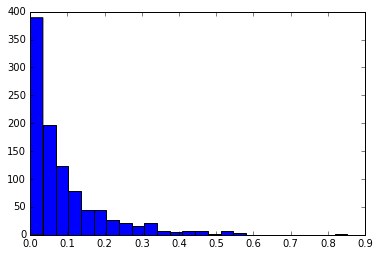

In [501]:
#Now, we can plot a quick histogram of the accident slopes

plt.hist(acc.slope, bins = 25)

In [772]:
#And lastly, as a quick ad-hoc test of whether slope and speed limit are predictors of SF accidents,
#we can generate a random sample of points on the road network, 'simulating' accidents,
#then extract the slopes at those points, 
#and then usea basic t-test to compare the slope means between the simulated data and our real data.

def sim_rand_speeds_and_slopes(n): # n = sample size
    
    mph = []
    
    slope = []
    
    #take a random sample of road segments, with replacement
    rand_rd_ids = np.random.choice(np.arange(len(roads)), size = 10000, replace = True)
    #take a random sample of proportional distances traveled along those segments when 'accidents' occur
    rand_rd_prop_dists = np.random.random(size = 10000)
    
    #for each randomly selected road segment
    for n, id in enumerate(rand_rd_ids):
        
        
        #try to get that road segment's speed limit (many segments don't have one)
        seg_mph = roads.ix[id]['maxspeed']
        try: 
            mph.append(int(re.search(re.compile('\d+'), seg_mph).group()))
        except Exception:
            mph.append(np.NaN)
        
               
               #get the line coordinates for that road segment
        line = roads.ix[id].geometry.coords.xy
        
        if len(line[0]) > 2:
            rand_start = np.random.choice(range(0,len(line[0])-2), size = 1)
            line = (line[0][rand_start:rand_start+2], line[1][rand_start:rand_start+2])
        
        #print line
        
        #calculate random x and y points, at prop dists traveled along the roads when simulated accidents occurred
        rand_x = np.min(line[0]) + np.abs(np.diff(line[0]))*rand_rd_prop_dists[n]
        rand_y = np.min(line[1]) + np.abs(np.diff(line[1]))*rand_rd_prop_dists[n]
        
        #print n, id, rand_rd_prop_dists[n], rand_x, rand_y
        
        #then extract the slope at our simulated accidents
        slope.append(extract_rast_val(Point([rand_x, rand_y]), corrected_slope))
    
    return(mph, slope)

In [773]:
mph, slope = sim_rand_speeds_and_slopes(10000)
mph = [m for m in mph if not np.isnan(m)]
slope = [s for s in slope if not np.isnan(s)]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


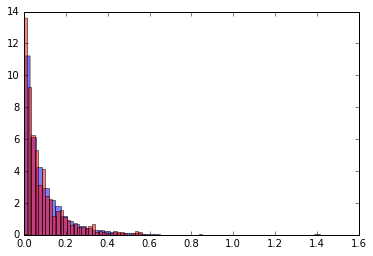

In [774]:
#Now we can get a heuristic look at the distributions of our actual and simulated slope data

ax = plt.hist(slope, bins = 50, alpha = 0.5, color = 'blue', normed = True);
plt.hist(acc.slope, bins = 50, alpha = 0.5, color = 'red', normed = True);

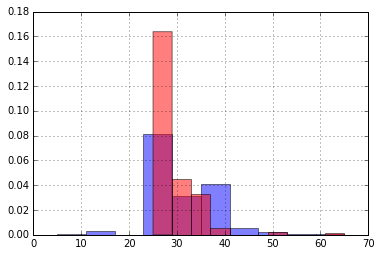

In [777]:
#And our actual and simulated speed limit data

ax = plt.hist(mph, bins = 10, alpha = 0.5, color = 'blue', normed = True);
acc['intsct_mph'].hist(bins = 10, alpha = 0.5, color = 'red', normed = True);

In [778]:
#And we can run a quick little formal test of a significant difference in means (assuming equal variance)

#For slope:

st.ttest_ind(acc.slope, slope)

(-1.4943385170076386, 0.13511655478437012)

In [781]:
#And for speed limit:

st.ttest_ind(acc.dropna(axis = 0, subset = ['intsct_mph']).intsct_mph, mph)

(-3.6014472099208681, 0.00032301099524486714)

In [798]:
#And we can also (perhaps more properly) use a chi-square test on the speed limits:

#We'll count the instances of all speed limits
real_mph = C(acc.dropna(axis = 0, subset = ['intsct_mph']).intsct_mph)
sim_mph = C(mph)

In [799]:
#Get a list of the speed limits at actual accidents, 
#which we can use to create equal-length vectors of frequencies observed for each of those speeds,
#to feed into our chi-square function

speeds = real_mph.keys()

In [800]:
#Now run our chi-square:

st.chisquare(f_exp = [sim_mph[s] for s in speeds], f_obs = [real_mph[s] for s in speeds])

(1556.0333063655762, 0.0)

In [805]:
#Seems that there's a weak signal of importance for slope, but a strong signal of importance of speed limit. 

#However, the difference between the null and actual accident speed limits is small:

print('Null mean speed limit is %0.2f.  Actual mean speed limit is %0.2f' % (np.mean(mph), np.mean(acc.intsct_mph)))

Null mean speed limit is 29.56.  Actual mean speed limit is 27.91


--------------------------
## Wrap-up

We hope that was a helpful (albeit whirlwind) introduction to the world of geospatial programming in Python!

Here are a few additional resources that you might find useful as you move ahead:

In [35]:
# Here are two lists of Python geospatial packages that, together, seem to hit all the important stuff: 
url = 'https://github.com/SpatialPython/spatial_python/blob/master/packages.md'
iframe = '<iframe src=' + url + ' width=700 height=350></iframe>'
HTML(iframe)

In [23]:
frame('http://carsonfarmer.com/2013/07/essential-python-geo-libraries/')

In [29]:
#An old-ish but still very useful book
#(includes a lot of explanation of geospatial concepts, which won't get outdated anytime soon)
frame('https://www.packtpub.com/application-development/learning-geospatial-analysis-python')

In [30]:
#Also keep in mind that you can use Python to program for ArcGIS:
#(this requires you to use Arc's own arcpy package, an API to the ArcDesktop tools)
frame('http://pro.arcgis.com/en/pro-app/arcpy/get-started/what-is-arcpy-.htm')

In [31]:
#And similarly, you can use Python to program QGIS as well:
frame('http://www.qgistutorials.com/en/docs/getting_started_with_pyqgis.html')

In [41]:
#And lastly, of course, reach out to our lovely, friendly, encouraging, helpful, and nicely perfumed 
#consultants here at D-Lab!
url = 'http://dlab.berkeley.edu/consulting'
iframe = '<iframe src=' + url + ' width=700 height=350></iframe>'
HTML(iframe)

In [33]:
#And also keep an eye on our upcoming workshops!
frame('http://dlab.berkeley.edu/training')